In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sns.set(rc={'figure.figsize' : (10, 10) })

In [3]:
tsp = pd.read_csv('tsp.csv', header=None)
tsp.head()

,0,1,2
0,1,565,575
1,2,25,185
2,3,345,750
3,4,945,685
4,5,845,655


In [4]:
X = tsp[[1, 2]].values

In [5]:
def path_len(path, X):
    l = 0
    prev = X[path[0]]
    for i in path[1:]:
        l += np.linalg.norm(X[i] - prev, ord=1)
        prev = X[i]
        
    return l

def plot_path(path, X, algo, l):
    print(f'Algorithm: {algo}. Path length: {l}')
    prev = X[path[0]]
    plt.scatter(X[:, 0], X[:, 1])
    for i in path[1:]:
        plt.plot([prev[0], X[i, 0], X[i, 0]], [prev[1], prev[1], X[i, 1]], c='pink')
        prev = X[i]
    plt.show()

# Монте-Карло поиск

In [6]:
def MonteCarloSearch(X):
    best_path = np.random.permutation(X.shape[0])
    best_len = path_len(best_path, X)
    best_it = 0
    it = 0
    while it - best_it < 30000:
        it += 1
        path = np.random.permutation(X.shape[0])
        len_ = path_len(path, X)
        if len_ < best_len:
            best_len = len_
            best_path = path
            
    return best_path, best_len

In [7]:
p, l = MonteCarloSearch(X)

Algorithm: Monte-Carlo search. Path length: 28960.0


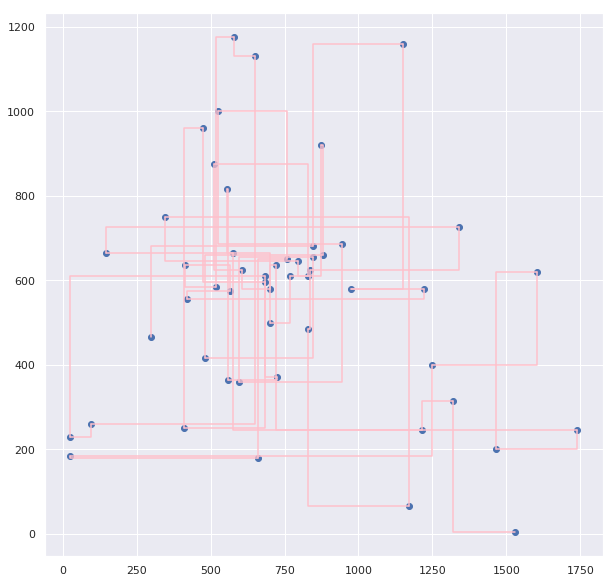

In [8]:
plot_path(p, X, 'Monte-Carlo search', l)

# Случайные блуждания

In [10]:
def RandomWalking(X):
    best_path = np.random.permutation(X.shape[0])
    best_len = path_len(best_path, X)
    best_it = 0
    it = 0
        
    path = best_path
    while it - best_it < 30000:
        it += 1
        idx = np.random.randint(low=0, high=X.shape[0], size=2)
        path[idx[0]], path[idx[1]] = path[idx[1]], path[idx[0]]
        len_ = path_len(path, X)
        if len_ < best_len:
            best_len = len_
            best_path = path
    return best_path, best_len

In [11]:
p1, l1 = RandomWalking(X)

Algorithm: Random Walking. Path length: 28445.0


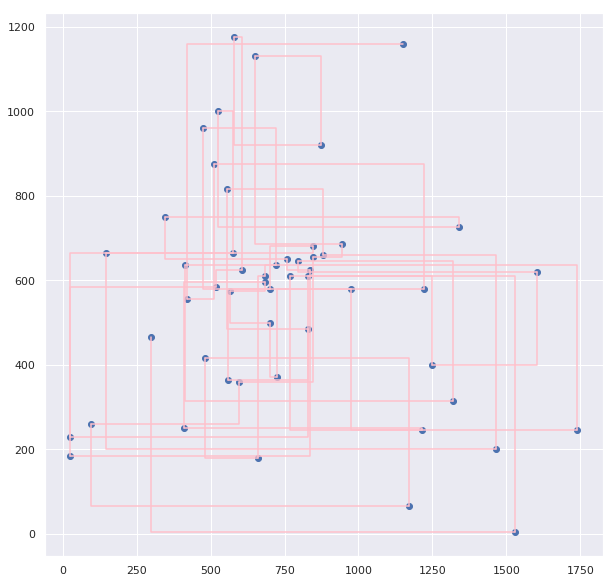

In [12]:
plot_path(p1, X, 'Random Walking', l1)

# Hill Climb

In [13]:
def HillClimb(X):
    path = np.random.permutation(X.shape[0])
    len_ = path_len(path, X)
    
    def try_walk(n_tries):
        idx = np.random.randint(low=0, high=X.shape[0], size=2)
        best_path = path.copy()
        best_path[idx[0]], best_path[idx[1]] = path[idx[1]], path[idx[0]]
        best_len = path_len(best_path, X)
        for _ in range(n_tries - 1):
            idx = np.random.randint(low=0, high=X.shape[0], size=2)
            new_path = path.copy()
            new_path[idx[0]], new_path[idx[1]] = path[idx[1]], path[idx[0]]
            new_len = path_len(new_path, X)
            if new_len < best_len:
                best_len = new_len
                best_path = new_path
        return best_path, best_len
    
    while True:
        p, l = try_walk(200)
        if l < len_:
            path = p
            len_ = l
        else:
            break
    return path, len_

In [14]:
p2, l2 = HillClimb(X)

Algorithm: Hill Climb. Path length: 13970.0


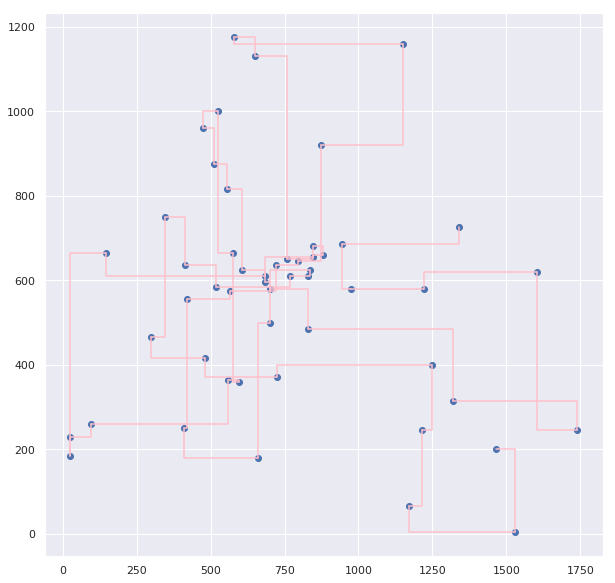

In [15]:
plot_path(p2, X, 'Hill Climb', l2)

# Отжиг

In [16]:
def SimulatedAnnealing(X, T=10000):
    path = np.random.permutation(X.shape[0])
    len_ = path_len(path, X)
    
    def P(de, t):
        return np.exp(de / t) / np.sum(np.exp(de / t))
    
    def try_walks(n_tries):
        swaps = [np.asarray([0, 0])]
        diffs = np.zeros(n_tries + 1)
        for i in range(n_tries):
            idx = np.random.randint(low=0, high=X.shape[0], size=2, dtype=int)
            swaps.append(idx)
            new_path = path.copy()
            new_path[idx[0]], new_path[idx[1]] = path[idx[1]], path[idx[0]]
            diffs[i + 1] = len_ - path_len(new_path, X)
        return swaps, diffs
    
    for t in range(T, 0, -1):
        swaps, diffs = try_walks(10)
        p = P(diffs, t)
        goto = np.random.choice(range(len(swaps)), p=p, size=1)[0]
        path[swaps[goto][0]], path[swaps[goto][1]] = path[swaps[goto][1]], path[swaps[goto][0]]
        len_ = len_ - diffs[goto]
        
    return path, len_

In [27]:
p3, l3 = SimulatedAnnealing(X, 3000)

Algorithm: Simulated Annealing. Path length: 14190.0


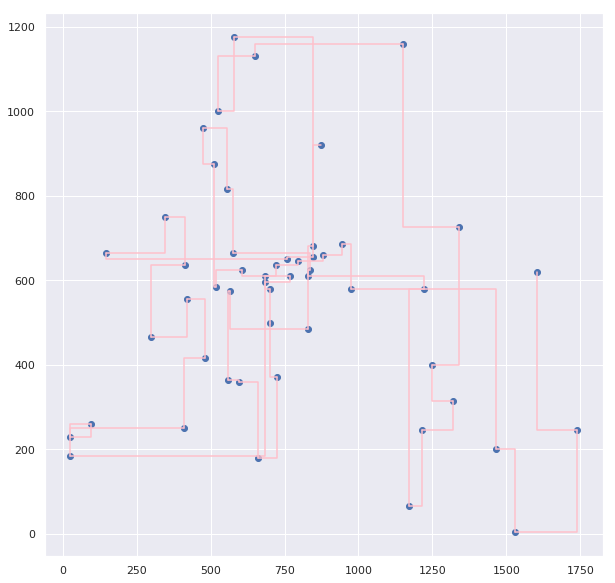

In [28]:
plot_path(p3, X, 'Simulated Annealing', l3)

In [20]:
def genetic_algorithm(X, population_size):
    species = []
    lens = []
    for _ in range(population_size):
        path = np.random.permutation(X.shape[0])
        len_ = path_len(path, X)
        species.append(path)
        lens.append(len_)
    
    def sort_together(l, s):
        l, s_idx = zip(*sorted(zip(lens, [i for i in range(len(lens))])))
        new_s = [s[i] for i in s_idx]
        return list(l), new_s
    
    def exchange(parents):
        unused_points = set([i for i in range(len(p1))])
        c = [np.random.choice(list(unused_points), size=1)[0]]
        unused_points.remove(c[0])
        n = 0
        
        
        for i in range(1, len(p1)):
            parent = np.random.choice([0, 1], p=[0.5, 0.5])
            next_ = -1
            
            idx, = np.where(parents[parent] == c[i - 1])
            idx = idx[0]
            if idx == len(p1) - 1 or (not parents[parent][idx + 1] in unused_points):
                parent = (parent + 1) % 2
                idx, = np.where(parents[parent] == c[i - 1])
                idx = idx[0]
                if idx == len(p1) - 1 or (not parents[parent][idx + 1] in unused_points):
                    next_ = np.random.choice(list(unused_points), size=1)[0]
                else:
                    next_ = parents[parent][idx + 1]
            else:
                next_ = parents[parent][idx + 1]
            
            unused_points.remove(next_)
            c.append(next_)
                
        return np.asarray(c)
    
    lens, species = sort_together(lens, species)
    sum_probs = sum([1 / l for l in range(1, len(lens) + 1)])
    probs = [1 / l / sum_probs for l in range(1, len(lens) + 1)]
    old_best = lens[0]
    old_best_it = 0
    it = 0
    
    while it - old_best_it < 3000:
        it += 1
        sum_probs = sum([1 / l for l in lens])
        p_idx = np.random.choice(range(population_size), p=probs, size=2)
        parents = [species[p_idx[0]], species[p_idx[1]]]
        childs = [exchange(parents), exchange(parents)]
        
        for i in range(2):
            mut = np.random.choice([0, 1], p=[0.05, 0.95])
            if mut == 0:
                idx = np.random.randint(0, X.shape[0], size=2)
                childs[i][idx[0]], childs[i][idx[1]] = childs[i][idx[1]], childs[i][idx[0]]
                
        c1_len = path_len(childs[0], X)
        c2_len = path_len(childs[1], X)
        
        if c1_len < lens[-1]:
            lens[-1] = c1_len
            species[-1] = childs[0]
            if c2_len < lens[-2]:
                lens[-2] = c2_len
                species[-2] = childs[1]
                
        elif c2_len < lens[-1]:
            lens[-1] = c2_len
            species[-1] = childs[1]
            
        else:
            continue
            
        lens, species = sort_together(lens, species)
        if lens[0] < old_best:
            old_best = lens[0]
            old_best_it = it
        
    return species[0], lens[0]

In [31]:
p4, l4 = genetic_algorithm(X, 400)

Algorithm: Genetic Algorithm. Path length: 11490.0


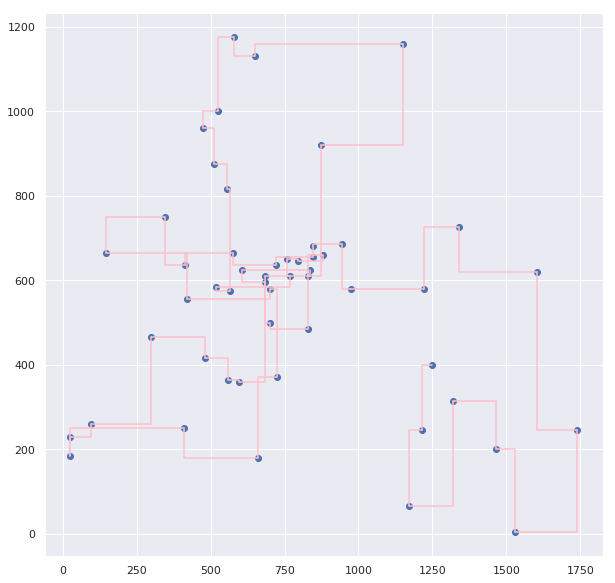

In [32]:
plot_path(p4, X, 'Genetic Algorithm', l4)